In [1]:
# !pip install rouge_score
# !pip install datasets
# !pip install accelerate -U
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install Rouge

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data

In [1]:
import tarfile
import os

tgz_file_path = '/kaggle/input/stories-highlights/dailymail_stories.tgz'
extract_dir = 'dailymail_stories'

os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(tgz_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

print("Extraction completed!")

Extraction completed!


In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import torch.nn as nn
import torch.optim as optim
import random
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import torch.nn.functional as F

def read_story_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    story_lines = []
    highlight_lines = []
    reading_highlights = False
    for line in lines:
        if line.strip() == "@highlight":
            reading_highlights = True
            continue
        if reading_highlights:
            highlight_lines.append(line.strip())
        else:
            story_lines.append(line.strip())

    story = ' '.join(story_lines)
    highlights = ' '.join(highlight_lines)
    return story, highlights


def load_dataset(data_path):
    articles = []
    highlights = []
    for filename in os.listdir(data_path):
        if filename.endswith('.story'):
            story, highlight = read_story_file(os.path.join(data_path, filename))
            articles.append(story)
            highlights.append(highlight)
    return articles, highlights

data_path = '/kaggle/working/dailymail_stories/dailymail/stories'
data_articles, data_highlights = load_dataset(data_path)

# Data Cleaning and Preprocessing

In [4]:
filtered_articles = []
filtered_highlights = []
for article, highlight in zip(data_articles, data_highlights):
    if len(highlight.split()) >= 4:
        filtered_articles.append(article)
        filtered_highlights.append(highlight)

data_articles = filtered_articles
data_highlights = filtered_highlights

In [5]:
# Print article strings before cleaning
print("Articles before cleaning:")
for article in data_articles[:2]:
    print(article)

Articles before cleaning:
By Anthony Bond  PUBLISHED:  08:21 EST, 23 March 2012  |  UPDATED:  12:08 EST, 23 March 2012  A British hostage who was killed by his captors in Nigeria during a rescue mission by UK special forces 'always made people feel special', mourners at his funeral heard today.  More than 600 people gathered to pay their respects to Chris McManus, 28, from Oldham, Greater Manchester, who was killed earlier this month.  Mr McManus and Italian co-worker Franco Lamolinara died on March 8 as Nigerian troops and UK Special Boat Service (SBS) commandos tried to end their captivity.  Great sadness: The body of Chris McManus is taken into his funeral service today. He died earlier this month while being held hostage in Nigeria  Devastated: Mr McManus' parents Laura and Michael at his funeral at Our Lady of Mount Carmel and St Patrick Church, Oldham  The deaths of both men sparked a diplomatic spat between London and Rome, with Italian politicians complaining they had not been 

In [6]:
data_article = data_articles[:10000]
len(data_article)

10000

In [7]:
data_highlight = data_highlights[:10000]
len(data_highlight)

10000

# Splitting the data into train, validation and test

In [8]:
from sklearn.model_selection import train_test_split

train_articles, temp_articles, train_highlights, temp_highlights = train_test_split(data_article, data_highlight, test_size=0.2, random_state=42)

val_articles, test_articles, val_highlights, test_highlights = train_test_split(temp_articles, temp_highlights, test_size=0.5, random_state=42)

print("Train set size:", len(train_articles))
print("Validation set size: ",len(val_articles))
print("Test set size: ",len(test_articles))

Train set size: 8000
Validation set size:  1000
Test set size:  1000


In [9]:
data_articles[0]

"The discovery of Martian clusters, known as ‘blueberries’, a decade ago provided some of the first evidence of liquid water on the red planet.  This incredible close up, taken by the Mars Rover Opportunity, reveals these spheres embedded in Martian rock like blueberries in a muffin.  The image is part of an exhibition by the Smithsonian's National Air and Space Museum presenting more than 50 of the best photographs from two rovers known as Spirit and Opportunity.  These hematite-rich spherules were embedded in this Martian rock like blueberries in a muffin and released over time by erosion. The Mars Rover Opportunity found this cluster at its Eagle Crater landing site and analysed their composition with its spectrometers. Hypotheses about their formation have contributed to the story of water on Mars  Ten years after Nasa landed the two rovers on Mars for a 90-day mission, one is still exploring, and the project has generated hundreds of thousands of images from the planet's surface. 

# Texual cleaning with stopwords

In [13]:
stopword_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [14]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    text_lowercased = text.lower()
    text_cleaned = BeautifulSoup(text_lowercased, "lxml").text
    text_cleaned = re.sub(r'\([^)]*\)', '', text_cleaned)
    text_cleaned = re.sub('"','', text_cleaned)
    text_cleaned = ' '.join([stopword_mapping[t] if t in stopword_mapping else t for t in text_cleaned.split(" ")])
    text_cleaned = re.sub(r"'s\b","",text_cleaned)
    text_cleaned = re.sub("[^a-zA-Z]", " ", text_cleaned)
    text_cleaned = re.sub('[m]{2,}', 'mm', text_cleaned)
    return text_cleaned

def articles_clean(article) :
    clean_article = text_cleaner(article)
    word_tokens = [w for w in clean_article.split() if not w in stop_words]
    article_words = [i for i in word_tokens if len(i) > 1]
    return (" ".join(article_words)).strip()

def summary_clean(summary) :
    clean_summary = text_cleaner(summary)
    word_tokens = clean_summary.split()
    # word_tokens = [w for w in clean_summary.split() if not w in stop_words]
    summary_words = [i for i in word_tokens if len(i) > 1]
    return (" ".join(summary_words)).strip()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
cleaned_train_articles = [articles_clean(t) for t in train_articles]
cleaned_train_highlights = [summary_clean(t) for t in train_highlights]
cleaned_val_articles = [articles_clean(t) for t in val_articles]
cleaned_val_highlights = [summary_clean(t) for t in val_highlights]
cleaned_test_articles = [articles_clean(t) for t in test_articles]
cleaned_test_highlights = [summary_clean(t) for t in test_highlights]

/tmp/ipykernel_34/1359083919.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_cleaned = BeautifulSoup(text_lowercased, "lxml").text


In [16]:
print("Articles after cleaning:")
for article in cleaned_train_articles[:2]:
    print(article)

Articles after cleaning:
older people warned dangers excessive drinking figures showed number suffering alcohol related mental health problems rocketed per cent decade latest research published today raises concerns baby boomer generation failing acknowledge damaging effects long term drinking new study found alcohol causing rise numbers diagnosed dementia experts say figures confirm epidemic late onset drinking retirement following bereavement number elderly people diagnosed dementia caused excessive alcohol consumption soared last decade appears wealthiest drinking london greatest number hospital admissions affluent areas including kensington islington eric appleby chief executive alcohol concern said born grown liberal approach alcohol added wake call drinking much often paying price mental physical well alcohol concern say elderly need aware dangers alcohol number mental disorders went new study carried dr tony rao consultant psychiatrist south london maudsley nhs foundation trust 

In [17]:
cleaned_train_articles[0]

'older people warned dangers excessive drinking figures showed number suffering alcohol related mental health problems rocketed per cent decade latest research published today raises concerns baby boomer generation failing acknowledge damaging effects long term drinking new study found alcohol causing rise numbers diagnosed dementia experts say figures confirm epidemic late onset drinking retirement following bereavement number elderly people diagnosed dementia caused excessive alcohol consumption soared last decade appears wealthiest drinking london greatest number hospital admissions affluent areas including kensington islington eric appleby chief executive alcohol concern said born grown liberal approach alcohol added wake call drinking much often paying price mental physical well alcohol concern say elderly need aware dangers alcohol number mental disorders went new study carried dr tony rao consultant psychiatrist south london maudsley nhs foundation trust examined trends hospital

# Tokenizing 

In [18]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
print("Highlights and their tokenized lists:")
for highlight in cleaned_train_highlights[:5]:
    print(highlight)
    print(word_tokenize(highlight))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Highlights and their tokenized lists:
the number of elderly patients with alcohol related dementia has soared the greatest number of admissions was in london affluent areas alcohol concern say that the baby boomer generation has more liberal approach to alcohol
['the', 'number', 'of', 'elderly', 'patients', 'with', 'alcohol', 'related', 'dementia', 'has', 'soared', 'the', 'greatest', 'number', 'of', 'admissions', 'was', 'in', 'london', 'affluent', 'areas', 'alcohol', 'concern', 'say', 'that', 'the', 'baby', 'boomer', 'generation', 'has', 'more', 'liberal', 'approach', 'to', 'alcohol']
judge richard marks qc oversaw the first trial of the sun journalists he was expected to officiate when the case is reheard later this year yesterday it emerged he had been substituted by judge charles wide row broke out in court over secret decision to appoint the new judge
['judge', 'richa

In [19]:
cleaned_train_highlights[0]

'the number of elderly patients with alcohol related dementia has soared the greatest number of admissions was in london affluent areas alcohol concern say that the baby boomer generation has more liberal approach to alcohol'

In [20]:
from collections import Counter
tokenized_highlights = [word_tokenize(highlight) for highlight in cleaned_train_highlights]
vocab = Counter([word for tokens in tokenized_highlights for word in tokens])

print("Top 10 vocabulary words:", vocab.most_common(10))

Top 10 vocabulary words: [('the', 3340), ('to', 2252), ('in', 1938), ('and', 1741), ('of', 1739), ('was', 920), ('on', 893), ('for', 876), ('is', 706), ('he', 600)]


# Data Vizualization

Mean text length: 389.133125
Mean summary length: 50.085


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


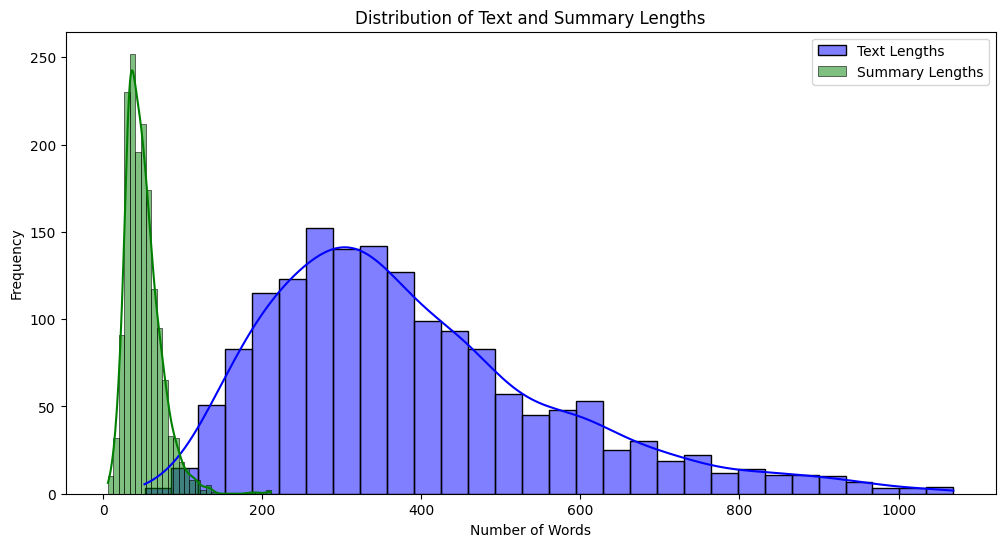

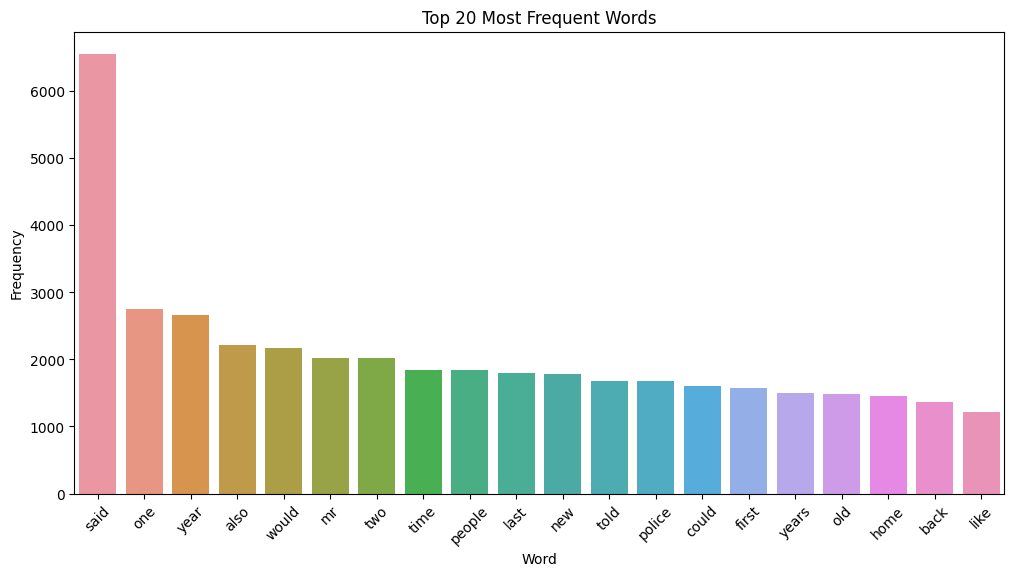

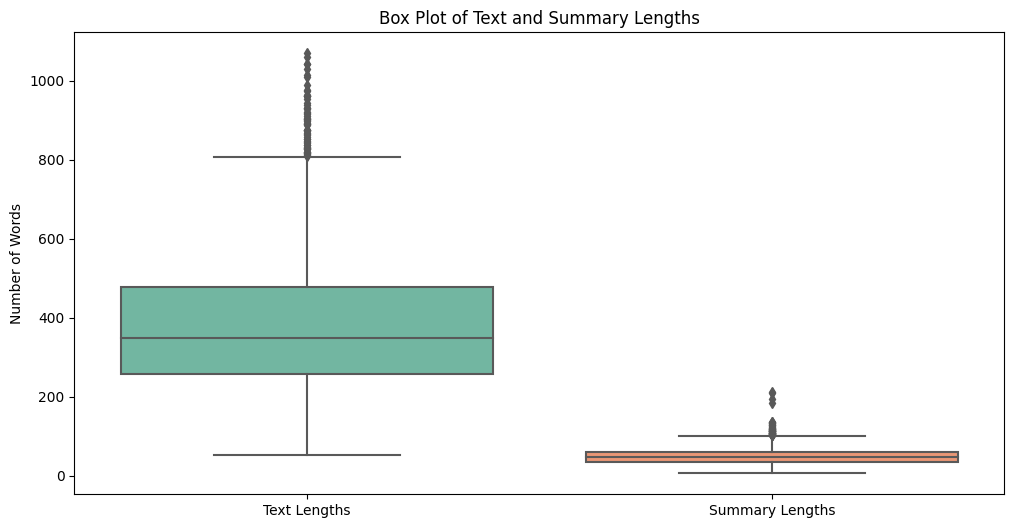

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Calculate text lengths and word counts
train_text_lengths = [len(text.split()) for text in cleaned_train_articles]
train_summary_lengths = [len(summary.split()) for summary in cleaned_train_highlights]

# Calculate word frequencies
all_words = ' '.join(cleaned_train_articles).split()
word_frequencies = Counter(all_words)

# Calculate mean word counts
mean_text_length = sum(train_text_lengths) / len(train_text_lengths)
mean_summary_length = sum(train_summary_lengths) / len(train_summary_lengths)

print(f"Mean text length: {mean_text_length}")
print(f"Mean summary length: {mean_summary_length}")

lengths_df = pd.DataFrame({
    'Text Lengths': train_text_lengths,
    'Summary Lengths': train_summary_lengths
})

# Plot the distribution of text and summary lengths in the same graph
plt.figure(figsize=(12, 6))
sns.histplot(lengths_df['Text Lengths'], bins=30, kde=True, color='blue', label='Text Lengths')
sns.histplot(lengths_df['Summary Lengths'], bins=30, kde=True, color='green', label='Summary Lengths')
plt.title('Distribution of Text and Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Convert word frequencies to DataFrame for plotting
word_freq_df = pd.DataFrame(word_frequencies.most_common(20), columns=['Word', 'Frequency'])

# Plot word frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=word_freq_df)
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()
# Box plot of text and summary lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=[train_text_lengths, train_summary_lengths], palette="Set2")
plt.xticks([0, 1], ['Text Lengths', 'Summary Lengths'])
plt.title('Box Plot of Text and Summary Lengths')
plt.ylabel('Number of Words')
plt.show()

In [22]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

train_data = Dataset.from_dict({'article': cleaned_train_articles, 'highlights': cleaned_train_highlights})
val_data = Dataset.from_dict({'article': cleaned_val_articles, 'highlights': cleaned_val_highlights})
test_data = Dataset.from_dict({'article': cleaned_test_articles, 'highlights': cleaned_test_highlights})

dataset = DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})

2024-07-06 20:05:27.473347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 20:05:27.473473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 20:05:27.596617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
dataset['train']['highlights'][0]

'the number of elderly patients with alcohol related dementia has soared the greatest number of admissions was in london affluent areas alcohol concern say that the baby boomer generation has more liberal approach to alcohol'

# Loading pretrained models with our dataset

In [24]:
from transformers import EncoderDecoderModel, BertTokenizer
def preprocess_data(dataset, tokenizer, max_input_length=400, max_target_length=50):
    inputs = dataset['article']
    targets = dataset['highlights']
    preprocessed_input = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')

    labels = tokenizer(text_target=targets, max_length=max_target_length, truncation=True, padding='max_length')
    preprocessed_input['labels'] = labels['input_ids']
    return preprocessed_input

def tokenize_and_preprocess(dataset, tokenizer):
    return dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Different Pre-Trained Models
model_names = ['patrickvonplaten/bert2bert_cnn_daily_mail','facebook/bart-base', 'google-t5/t5-base']
models = {}
tokenizers = {}

for model_name in model_names:
    if model_name == "patrickvonplaten/bert2bert_cnn_daily_mail":
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = EncoderDecoderModel.from_pretrained(model_name).to(device)
        tokenizers[model_name] = tokenizer
        models[model_name] = model
    elif "bart" in model_name:
        tokenizers[model_name] = BartTokenizer.from_pretrained(model_name)
        models[model_name] = BartForConditionalGeneration.from_pretrained(model_name).to(device)
    elif "t5" in model_name:
        tokenizers[model_name] = T5Tokenizer.from_pretrained(model_name)
        models[model_name] = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

tokenized_datasets = {model_name: tokenize_and_preprocess(dataset, tokenizers[model_name]) for model_name in model_names}



tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [25]:
from transformers import EncoderDecoderModel, BertTokenizer, EncoderDecoderConfig,BertConfig

In [27]:
tokenized_datasets[model_name]['validation']['highlights'][:10]

['registrar in llandudno saw bride holding hands with real boyfriend svetlana kokenyova from czech republic to be paid to marry ali ansar from pakistan so he could stay in uk the pair and kokenyova boyfriend vladimir bango jailed on tuesday',
 'chelsea have not lost with nemanja matic on the field since april since then he has played winning and drawing just seven matic is strong powerful tactically and technically excellent for chelsea the blues can still win four trophies this season and matic will be at the heart of the team as they strive to make history',
 'anthony stokes has scored seven goals for celtic so far this season he signed new three year deal at parkhead back in october cardiff are interested in luring the striker back into english league football the welsh club are ninth in the championship and looking for quick return to the premier league after last season relegation',
 'just want everybody to be happy and want to sleep in that what want for christmas want to sleep l

In [28]:
tokenized_datasets[model_name]['validation']['labels'][0]

[3,
 5200,
 291,
 16,
 3,
 195,
 232,
 76,
 26,
 29,
 32,
 1509,
 11738,
 3609,
 1780,
 28,
 490,
 18124,
 3,
 7,
 162,
 17,
 1618,
 9,
 3,
 157,
 1825,
 35,
 63,
 6194,
 45,
 3,
 75,
 776,
 524,
 20237,
 12,
 36,
 1866,
 12,
 20111,
 3,
 4288,
 46,
 7,
 291,
 45,
 3,
 16864,
 1]

# Integrating with AI tool WANDB

In [44]:
import wandb
import torch

wandb.init(project="text_summarization")

eval/loss,▆▇▇███▅▅▅▅▆▆▁▁▁▁▁▁
eval/runtime,▇▇▇▇█▇▁▁▁▁▁▁██████
eval/samples_per_second,▁▁▁▁▁▁██████▁▁▁▁▁▁
eval/steps_per_second,▁▁▁▁▁▁██████▁▁▁▁▁▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▇▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▂▃▄▄▅▅▆▆▇▇█
train/global_step,▁▂▂▃▃▄▄▅▅▆▇▇█▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▂▃▄▄▅▅▆▆▇▇█
train/grad_norm,▅▅▅▄▄▄█▄▃▂▃▂▂▂▅▄▄▄▄▄▆▅▅▄▄▅▄▂▂▁▂▁▁▂▁▁▁▁▁▂
train/learning_rate,██▇▇▆▅▅▄▄▃▃▂▂▁█▇▇▆▅▅▅▄▃▃▂▂▁█▇▇▆▆▅▅▄▃▃▂▂▁
train/loss,█▇▇▅▄▄▃▃▂▂▂▁▁▁█▇▆▅▅▄▅▅▃▄▃▃▃▆▅▅▅▄▄▄▄▃▄▃▃▃
eval/loss,1.82896
eval/runtime,4.9316


# Fine tuning the models

In [ ]:
import wandb

def training_args(output_path):
    return TrainingArguments(
        output_dir=output_path,
        eval_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        weight_decay=0.01,
        save_total_limit=1,
        num_train_epochs=5,
        logging_dir='./logs',
        logging_steps=10,
        gradient_checkpointing=True,
        fp16_opt_level='O2',
        report_to="wandb"
    )

# Training Google T5 model with fine tuning 

In [31]:
for model_name in ['google-t5/t5-base']:
    run = wandb.init(project="text_summarization", name=model_name.replace('/', '_'))
    model = models[model_name]
    tokenizer = tokenizers[model_name]
    args = training_args(output_path=f'/kaggle/working/wandb/{model_name}')
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets[model_name]['train'],
        eval_dataset=tokenized_datasets[model_name]['validation'],
        tokenizer=tokenizer
    )
    print(f"Training {model_name}...")
    trainer.train()
    print(f"Evaluating {model_name}...")
    results = trainer.evaluate()
    print(f"Results for {model_name}: {results}")
    model_filename = f"{model_name.replace('/', '_')}.pth"
    torch.save(trainer.model.state_dict(), model_filename)
    run.finish()


train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/grad_norm,▅▄██▆▂▅▃█▄▃▄▄▃▃▂▁▂▁▂▁▁▃▆▂▃
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
train/loss,█▆▄▃▂▂▂▃▂▃▂▁▂▃▁▃▂▂▂▁▁▂▂▂▂▂
train/epoch,0.325
train/global_step,260
train/grad_norm,14.53695
train/learning_rate,5e-05
train/loss,3.1993


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Training google-t5/t5-base...


Epoch,Training Loss,Validation Loss
1,2.393000,1.926197
2,2.127600,1.889502
3,1.568100,1.888580
4,1.593200,1.890463
5,1.355500,1.901680


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Evaluating google-t5/t5-base...


Results for google-t5/t5-base: {'eval_loss': 1.9016804695129395, 'eval_runtime': 4.9207, 'eval_samples_per_second': 40.645, 'eval_steps_per_second': 20.322, 'epoch': 5.0}


eval/loss,█▁▁▁▃▃
eval/runtime,▁▂▃▄█▆
eval/samples_per_second,█▇▆▄▁▃
eval/steps_per_second,█▇▆▄▁▃
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▂▂▂▁▁▁▂
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▅▆▅▅▅▅▅▅▅▄▄▃▄▅▄▃▃▄▄▃▄▃▂▃▃▂▂▃▁▃▃▄▂▂▂▃▂▂▂
eval/loss,1.90168
eval/runtime,4.9207


# Training BErt2Bert and Facebook bart models

In [29]:
# Train and evaluate all 3 model
for model_name in ['patrickvonplaten/bert2bert_cnn_daily_mail','facebook/bart-base']:
    run = wandb.init(project="text_summarization", name=model_name.replace('/', '_'))
    model = models[model_name]
    tokenizer = tokenizers[model_name]
    args = training_args(output_path=f'/kaggle/working/wandb/{model_name}')
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets[model_name]['train'],
        eval_dataset=tokenized_datasets[model_name]['validation'],
        tokenizer=tokenizer
    )
    print(f"Training {model_name}...")
    trainer.train()
    print(f"Evaluating {model_name}...")
    results = trainer.evaluate()
    print(f"Results for {model_name}: {results}")
    model_filename = f"{model_name.replace('/', '_')}.pth"
    torch.save(trainer.model.state_dict(), model_filename)
    run.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training patrickvonplaten/bert2bert_cnn_daily_mail...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/opt/conda/lib/python3.10/site-packages/t

Epoch,Training Loss,Validation Loss
1,2.813300,2.695372
2,1.713000,2.791706
3,1.262900,2.872651
4,0.713600,2.957250
5,0.432200,3.001941


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_

Evaluating patrickvonplaten/bert2bert_cnn_daily_mail...


Results for patrickvonplaten/bert2bert_cnn_daily_mail: {'eval_loss': 3.001941204071045, 'eval_runtime': 4.797, 'eval_samples_per_second': 41.693, 'eval_steps_per_second': 20.846, 'epoch': 5.0}
Training facebook/bart-base...


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.749000,2.503798
2,2.085800,2.456363
3,1.899100,2.478445
4,1.462100,2.514899
5,1.053700,2.589591


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a Generation

Evaluating facebook/bart-base...


Results for facebook/bart-base: {'eval_loss': 2.5895910263061523, 'eval_runtime': 2.6537, 'eval_samples_per_second': 75.367, 'eval_steps_per_second': 37.684, 'epoch': 5.0}
Training google-t5/t5-base...


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,1.918600,1.845171
2,1.687500,1.817732
3,1.759800,1.813127
4,1.419400,1.821935
5,1.376400,1.828956


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Evaluating google-t5/t5-base...


Results for google-t5/t5-base: {'eval_loss': 1.8289560079574585, 'eval_runtime': 4.9316, 'eval_samples_per_second': 40.555, 'eval_steps_per_second': 20.277, 'epoch': 5.0}


In [29]:
model_names

['patrickvonplaten/bert2bert_cnn_daily_mail',
 'facebook/bart-base',
 'google-t5/t5-base']

In [30]:
dataset['train']['article'][0]

'vladimir putin fighting flab luxury spanish health resort loved naomi campbell kylie minogue russian leader involved ugly spat prince charles reportedly signed anti ageing weight loss programme sha wellness clinic costa blanca respected spanish newspaper la razon said putin attacked prince wales saturday comparing hitler turned spa near alicante group models scroll video holiday detox president vladimir putin pictured russia reportedly travelled spain detox beautiful setting sha wellness clinic spain vladimir putin rumoured detoxing said stuck detox diet whole cereal grains beans veg daily cup miso soup stay followed russia annexation crimea march known much stay sha features suites set zen gardens swimming pools waterfalls cost long lasted one night stay sq metre royal suite guests offered heliport service private parking swimming pool costs night medical miracle sha wellness clinic promises help guests change lifestyle celebrity haunt kylie minogue naomi campbell gwyneth paltrow rep

In [31]:
dataset['train']['highlights'][0]

'luxurious sha wellness clinic is popular with list celebrities naomi campbell and kylie minogue have both visited resort in spain putin is rumoured to have stayed at the spa after spate with prince charles russian president signed up for anti ageing and weight loss programme'

# Evaluating the models

In [32]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    max_length=256,
    num_beams=8,
    length_penalty=0.8,
    forced_eos_token_id=1,
)

generated_summary={}
text=dataset['train']['article'][0]
for model_name, model in models.items():
    tokenizer = tokenizers[model_name]

    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='longest').to(device)
    summary_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], generation_config=generation_config)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summary[model_name] = summary
    print(f"Model: {model_name}")
    print(f"Summary: {summary}")
    print()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model: patrickvonplaten/bert2bert_cnn_daily_mail

Summary: luxurious sha wellness clinic is popular with list celebrities naomi campbell and kylie minogue have both visited resort in spain putin is rumoured to have stayed at the spa after spate with prince charles russian president signed up for anti ageing and weight loss programme alcohol and sugar added to the drink alcohol was also used for the same degree of weight loss alcohol used alcohol and dysmorportivivivivivivy alcohol and sugar was added to the same amount alcohol and sugar was added to the diet alcohol and sugar alcohol to the same amount as per day alcohol alcohol and sugar added to the diet alcohol and sugar regime alcohol and sugar regime alcohol and the same amount of alcohol sapriment sapriment alcohol alcohol and the same amount of alcohol in the alcohol and the same amount as per cent of alcohol alcohol alcohol and alcohol used for the same amount of alcohol alcohol and alcohol and the same amount of alcohol alcoho

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model: facebook/bart-base

Summary: vladimir putin is rumoured to have travelled to spain to detox spa putin has reportedly signed anti ageing weight loss programme at the sha wellness clinic in costa blanca respected spanish newspaper la razon said putin



Model: google-t5/t5-base

Summary: vladimir putin reportedly travelled to spain to detox at sha wellness clinic prince charles reportedly signed up to the programme he compared hitler to spa in alicante




In [33]:
generated_summary_facebook=generated_summary['facebook/bart-base']
generated_summary_google=generated_summary['google-t5/t5-base']
generated_summary_bert2bert=generated_summary['patrickvonplaten/bert2bert_cnn_daily_mail']

# Evaluation metrics for each model

In [34]:
import torch
from rouge import Rouge
print("for facebook/bart-base")
generated_summary = generated_summary_facebook
reference_summary = dataset['train']['highlights'][0]
# Initialize the ROUGE object
rouge = Rouge()
# Calculate ROUGE for the generated and reference summaries
scores = rouge.get_scores(generated_summary, reference_summary,avg=True)
# Print the results
# Print the results, each score on a new line
print("ROUGE Scores:")
for key, values in scores.items():
    print(f"{key}:")
    for measure, score in values.items():
        print(f"  {measure}: {score:.4f}")

for facebook/bart-base

ROUGE Scores:

rouge-1:

  r: 0.4634

  p: 0.5938

  f: 0.5205

rouge-2:

  r: 0.2273

  p: 0.2857

  f: 0.2532

rouge-l:

  r: 0.2927

  p: 0.3750

  f: 0.3288


In [43]:
import os
# Define the path in your Google Drive where you want to save the models
drive_path = '/content/drive/MyDrive/'
os.makedirs(drive_path, exist_ok=True)  # Creates the directory if it doesn't exist


In [44]:
import torch

# Assuming 'trainers' is your dictionary of trained models
for model_name, trainer in trainers.items():
    # Create a safe filename by replacing '/' with '_'
    model_filename = f"{model_name.replace('/', '_')}.pth"
    full_path = os.path.join(drive_path, model_filename)

    # Save the model's state dictionary
    torch.save(trainer.model.state_dict(), full_path)
    print(f"Saved {model_name} model to {full_path}")


Saved patrickvonplaten/bert2bert_cnn_daily_mail model to /content/drive/MyDrive/patrickvonplaten_bert2bert_cnn_daily_mail.pth

Saved facebook/bart-base model to /content/drive/MyDrive/facebook_bart-base.pth

Saved google-t5/t5-base model to /content/drive/MyDrive/google-t5_t5-base.pth


In [39]:
!pip install bert-score




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00




















































In [45]:
import torch
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

generated_summary = generated_summary_facebook
reference_summary = dataset['train']['highlights'][0]
rouge = Rouge()
rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)
P, R, F1 = bert_score([generated_summary], [reference_summary], lang='en')
print("ROUGE Scores:")
for key, values in rouge_scores.items():
    print(f"{key}:")
    for measure, score in values.items():
        print(f"  {measure}: {score:.4f}")

print("for facebook-bart model")
print(f"BERT Precision: {P.item():.4f}")
print(f"BERT Recall: {R.item():.4f}")
print(f"BERT F1 Score: {F1.item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE Scores:

rouge-1:

  r: 0.4634

  p: 0.5938

  f: 0.5205

rouge-2:

  r: 0.2273

  p: 0.2857

  f: 0.2532

rouge-l:

  r: 0.2927

  p: 0.3750

  f: 0.3288

for facebook-bart model

BERT Precision: 0.8584

BERT Recall: 0.8532

BERT F1 Score: 0.8558


In [46]:
import torch
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

generated_summary = generated_summary_google
reference_summary = dataset['train']['highlights'][0]
rouge = Rouge()
rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)
P, R, F1 = bert_score([generated_summary], [reference_summary], lang='en')
print("ROUGE Scores:")
for key, values in rouge_scores.items():
    print(f"{key}:")
    for measure, score in values.items():
        print(f"  {measure}: {score:.4f}")

print("for google-t5 model")
print(f"BERT Precision: {P.item():.4f}")
print(f"BERT Recall: {R.item():.4f}")
print(f"BERT F1 Score: {F1.item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE Scores:

rouge-1:

  r: 0.3659

  p: 0.6522

  f: 0.4687

rouge-2:

  r: 0.0909

  p: 0.1538

  f: 0.1143

rouge-l:

  r: 0.1951

  p: 0.3478

  f: 0.2500

for google-t5 model

BERT Precision: 0.8605

BERT Recall: 0.8468

BERT F1 Score: 0.8536


In [47]:
import torch
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

generated_summary = generated_summary_bert2bert
reference_summary = dataset['train']['highlights'][0]
rouge = Rouge()
rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)
P, R, F1 = bert_score([generated_summary], [reference_summary], lang='en')
print("ROUGE Scores:")
for key, values in rouge_scores.items():
    print(f"{key}:")
    for measure, score in values.items():
        print(f"  {measure}: {score:.4f}")

print("for bert2bert model")
print(f"BERT Precision: {P.item():.4f}")
print(f"BERT Recall: {R.item():.4f}")
print(f"BERT F1 Score: {F1.item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE Scores:

rouge-1:

  r: 1.0000

  p: 0.6721

  f: 0.8039

rouge-2:

  r: 1.0000

  p: 0.4681

  f: 0.6377

rouge-l:

  r: 1.0000

  p: 0.6721

  f: 0.8039

for bert2bert model

BERT Precision: 0.8077

BERT Recall: 0.9751

BERT F1 Score: 0.8836
